In [3]:
import os
# Set working directory
os.chdir("D:/ACP")  # Windows path fix: use forward slash or raw string

print("Current Working Directory:", os.getcwd())

Current Working Directory: D:\ACP


In [4]:
import csv
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import Counter
from math import log2

# Function to calculate sequence complexity (Shannon entropy)
def sequence_complexity(epitope):
    counts = Counter(epitope)
    total = len(epitope)
    entropy = -sum((count/total) * log2(count/total) for count in counts.values())
    return entropy

# Function to count potential phosphorylation sites (S, T, Y)
def count_phosphorylation_sites(epitope):
    return epitope.count('S') + epitope.count('T') + epitope.count('Y')

# Function to count potential glycosylation sites (N-X-S/T)
def count_glycosylation_sites(epitope):
    count = 0
    for i in range(len(epitope) - 2):
        if epitope[i] == 'N' and epitope[i+2] in 'ST' and epitope[i+1] != 'P':
            count += 1
    return count

# Function to predict disulfide bonds (basic heuristic, not highly accurate)
def predict_disulfide_bonds(epitope):
    return epitope.count('C') // 2

# Function to extract features from an epitope
def extract_epitope_features(epitope):
    if len(epitope) == 0:
        return {}
    analyzed_seq = ProteinAnalysis(epitope)
    
    features = {
        "epitope": epitope,
        "length": len(epitope),
        "aa_composition": dict(Counter(epitope)),
        "percentage_composition": {aa: count / len(epitope) * 100 for aa, count in Counter(epitope).items()},
        "molecular_weight": analyzed_seq.molecular_weight(),
        "aromaticity": analyzed_seq.aromaticity(),
        "instability_index": analyzed_seq.instability_index(),
        "hydrophobicity": analyzed_seq.gravy(),
        "isoelectric_point": analyzed_seq.isoelectric_point(),
        "extinction_coefficient": analyzed_seq.molar_extinction_coefficient()[0],  # assuming reduced Cys
        "secondary_structure_fraction": analyzed_seq.secondary_structure_fraction(),
        "flexibility": analyzed_seq.flexibility(),
        "charge_at_pH7": analyzed_seq.charge_at_pH(7.0),
        "disulfide_bonds": predict_disulfide_bonds(epitope),
        "phosphorylation_sites": count_phosphorylation_sites(epitope),
        "glycosylation_sites": count_glycosylation_sites(epitope),
        "sequence_complexity": sequence_complexity(epitope)
    }
    return features

def flatten_features(features):
    if not features:
        return {}
    
    flexibility_list = features.get("flexibility", [])
    if flexibility_list:
        flexibility_avg = sum(flexibility_list) / len(flexibility_list)
    else:
        flexibility_avg = 0  # Or use another default value
    
    flattened = {
        "epitope": features["epitope"],
        "length": features["length"],
        "molecular_weight": features["molecular_weight"],
        "aromaticity": features["aromaticity"],
        "instability_index": features["instability_index"],
        "hydrophobicity": features["hydrophobicity"],
        "isoelectric_point": features["isoelectric_point"],
        "extinction_coefficient": features["extinction_coefficient"],
        "helix_fraction": features["secondary_structure_fraction"][0],
        "turn_fraction": features["secondary_structure_fraction"][1],
        "sheet_fraction": features["secondary_structure_fraction"][2],
        "flexibility": flexibility_avg,
        "charge_at_pH7": features["charge_at_pH7"],
        "disulfide_bonds": features["disulfide_bonds"],
        "phosphorylation_sites": features["phosphorylation_sites"],
        "glycosylation_sites": features["glycosylation_sites"],
        "sequence_complexity": features["sequence_complexity"]
    }
    
    # Add amino acid composition and percentage composition
    for aa, count in features["aa_composition"].items():
        flattened[f"aa_{aa}_count"] = count
    
    for aa, percentage in features["percentage_composition"].items():
        flattened[f"aa_{aa}_percentage"] = percentage
    
    return flattened

# File paths
input_file = "acp.txt"
output_file = "acp_biopython.csv"

# Read epitopes from the text file
with open(input_file, "r") as f:
    epitopes = f.read().splitlines()

# Open CSV file for writing
with open(output_file, "w", newline="") as csvfile:
    # Define CSV column headers
    fieldnames = [
        "epitope", "length", "molecular_weight", "aromaticity", 
        "instability_index", "hydrophobicity", 
        "isoelectric_point", "extinction_coefficient", 
        "helix_fraction", "turn_fraction", "sheet_fraction", 
        "flexibility", "charge_at_pH7", "disulfide_bonds",
        "phosphorylation_sites", "glycosylation_sites", 
        "sequence_complexity"
    ]
    
    # Adding amino acid columns dynamically based on the dataset
    all_amino_acids = {f"aa_{aa}_count" for epitope in epitopes for aa in set(epitope)}
    all_amino_acids_percentage = {f"aa_{aa}_percentage" for epitope in epitopes for aa in set(epitope)}
    
    fieldnames.extend(sorted(all_amino_acids))
    fieldnames.extend(sorted(all_amino_acids_percentage))

    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    # Process each epitope and write to the CSV
    for epitope in epitopes:
        features = extract_epitope_features(epitope)
        flattened_features = flatten_features(features)

        # Fill empty entries with 0
        for field in fieldnames:
            if field not in flattened_features:
                flattened_features[field] = 0
                
        writer.writerow(flattened_features)
    
print(f"Feature extraction completed. Data saved to {output_file}")

Feature extraction completed. Data saved to acp_biopython.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the file
file_path = 'acp_final_combined.csv'
df = pd.read_csv(file_path)

# Inspect the first few rows to understand its structure
df.head()


,ID,Sequence,Label,length,molecular_weight,aromaticity,instability_index,hydrophobicity,isoelectric_point,extinction_coefficient,...,YM10.1,YN10.1,YP10.1,YQ10.1,YR10.1,YS10.1,YT10.1,YV10.1,YW10.1,YY10.1
0,ACP_1,AIGSILGALAKGLPTLISWIKNR,1,23,2392.8802,0.043478,15.239130,0.730435,11.166392,5500,...,0,0,0,0,0,0,0,0,0,0
1,ACP_2,AWKKWAKAWKWAKAKWWAKAA,1,21,2601.1040,0.285714,-11.947619,-0.871429,10.778485,33000,...,0,0,0,0,0,0,0,0,0,0
2,ACP_3,FAKALAKLAKKLL,1,13,1414.8203,0.076923,-3.830769,0.738462,10.477740,0,...,0,0,0,0,0,0,0,0,0,0
3,ACP_4,FAKFLAKFLKKAL,1,13,1524.9324,0.230769,2.700000,0.738462,10.477740,0,...,0,0,0,0,0,0,0,0,0,0
4,ACP_5,FAKIIAKIAKIAKKIL,1,16,1769.3078,0.062500,0.187500,1.050000,10.602487,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Filter sequences based on length criteria: keep only those with length between 5 and 50 (inclusive)
filtered_df = df[(df['length'] >= 5) & (df['length'] <= 50)]

# Save the filtered data to a new CSV file
filtered_file_path = "acp_filtered_len5_50.csv"
filtered_df.to_csv(filtered_file_path, index=False)

filtered_file_path

'acp_filtered_len5_50.csv'

Positive sequences: 468 (50.70%)
Negative sequences: 455 (49.30%)


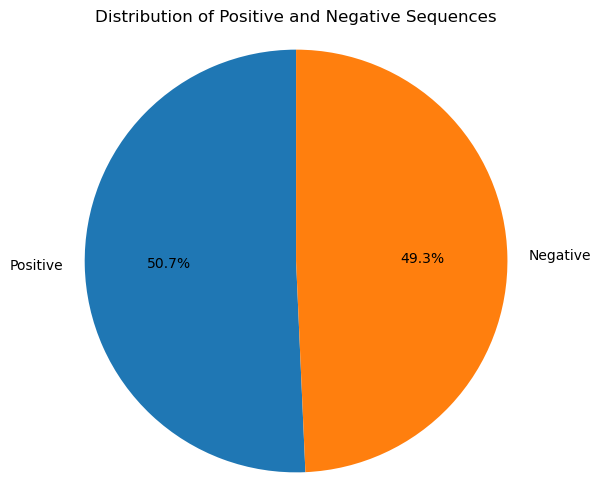

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the file
file_path = 'acp_filtered_len5_50.csv'
df = pd.read_csv(file_path)

# Count positive and negative sequences based on 'Label' column ( 1 = positive, 0 = negative)
counts = df['Label'].value_counts()
positive_count = counts.get(1, 0)
negative_count = counts.get(0, 0)

# Calculate percentages
total = positive_count + negative_count
positive_pct = (positive_count / total) * 100 if total else 0
negative_pct = (negative_count / total) * 100 if total else 0

# Print counts and percentages
print(f"Positive sequences: {positive_count} ({positive_pct:.2f}%)")
print(f"Negative sequences: {negative_count} ({negative_pct:.2f}%)")

# Plot pie chart
labels = ['Positive', 'Negative']
sizes = [positive_pct, negative_pct]
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Positive and Negative Sequences')
plt.axis('equal')
plt.show()


In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('acp_filtered_len5_50.csv')

# Separate columns
df_features = df.iloc[:, 3:]  # Features start from 4th column
df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_features), columns=df_features.columns)

# Combine with first three columns (ID, Sequence, Label)
df_combined = pd.concat([df.iloc[:, :3].reset_index(drop=True), df_scaled], axis=1)

# Save or use df_combined as needed
df_combined.to_csv('acp_scaled.csv', index=False)

from sklearn.model_selection import train_test_split

# Assume df_combined is your scaled DataFrame with first three columns: ID, Sequence, Label
X = df_combined.iloc[:, 3:]  # Features
y = df_combined['Label']     # Labels

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine with IDs, Sequences, Labels
df_train = pd.concat([df_combined.iloc[y_train.index, :3].reset_index(drop=True), X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
df_test = pd.concat([df_combined.iloc[y_test.index, :3].reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Save to CSV
df_train.to_csv('acp_train_data.csv', index=False)
df_test.to_csv('acp_test_data.csv', index=False)


Positive sequences: 374 (50.68%)
Negative sequences: 364 (49.32%)


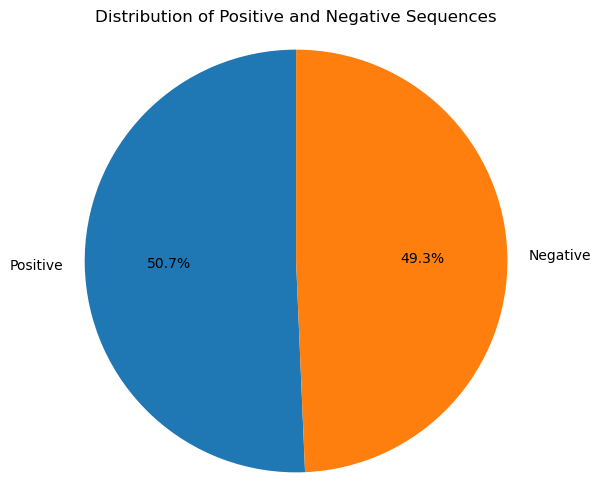

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the file
file_path = 'acp_train_data.csv'
df = pd.read_csv(file_path)

# Count positive and negative sequences based on 'Label' column ( 1 = positive, 0 = negative)
counts = df['Label'].value_counts()
positive_count = counts.get(1, 0)
negative_count = counts.get(0, 0)

# Calculate percentages
total = positive_count + negative_count
positive_pct = (positive_count / total) * 100 if total else 0
negative_pct = (negative_count / total) * 100 if total else 0

# Print counts and percentages
print(f"Positive sequences: {positive_count} ({positive_pct:.2f}%)")
print(f"Negative sequences: {negative_count} ({negative_pct:.2f}%)")

# Plot pie chart
labels = ['Positive', 'Negative']
sizes = [positive_pct, negative_pct]
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Positive and Negative Sequences')
plt.axis('equal')
plt.show()

Positive sequences: 94 (50.81%)
Negative sequences: 91 (49.19%)


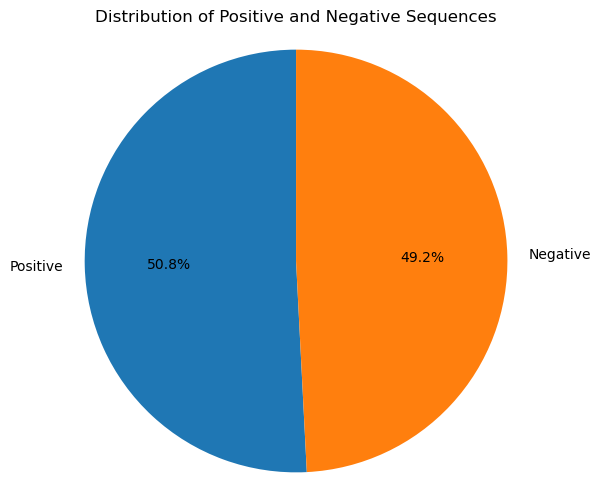

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the file
file_path = 'acp_test_data.csv'
df = pd.read_csv(file_path)

# Count positive and negative sequences based on 'Label' column ( 1 = positive, 0 = negative)
counts = df['Label'].value_counts()
positive_count = counts.get(1, 0)
negative_count = counts.get(0, 0)

# Calculate percentages
total = positive_count + negative_count
positive_pct = (positive_count / total) * 100 if total else 0
negative_pct = (negative_count / total) * 100 if total else 0

# Print counts and percentages
print(f"Positive sequences: {positive_count} ({positive_pct:.2f}%)")
print(f"Negative sequences: {negative_count} ({negative_pct:.2f}%)")

# Plot pie chart
labels = ['Positive', 'Negative']
sizes = [positive_pct, negative_pct]
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Positive and Negative Sequences')
plt.axis('equal')
plt.show()